# Final Project CS209b
## Autoregression Flu - April 30
### Benjamin Levy, Will Fried, Dimitris Vamvourellis & Matthieu Meeus

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AutoReg

In [3]:
# open all csv files and save them in one dataframe
data = pd.DataFrame()
directory = 'flu_ground_truth'
for filename in os.listdir(directory):
    if data.empty:
        state = filename[13:-4]
        data = pd.read_csv(directory + '/' + filename)
        data.rename(columns={"wili": state}, inplace = True)
    else:
        state = filename[13:-4]
        state_data = pd.read_csv(directory + '/' + filename)
        data[state] = state_data['wili']  

In [4]:
data

,time,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,...,Tennessee,Texas,Utah,Vermont,Virgin Islands,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,2010-40,2.134770,0.875146,0.674721,0.696056,1.954120,0.660684,0.078309,0.100125,2.80877,...,0.274655,2.06514,0.747696,1.476410,0.0001,1.143430,0.510041,1.597410,0.465022,0.632911
1,2010-41,2.059990,1.128270,0.749939,0.674157,2.152660,0.628621,0.238095,0.368550,2.89079,...,0.499492,2.09394,0.410939,1.357770,0.0001,1.236530,1.040070,1.589680,0.581832,0.440621
2,2010-42,1.942240,0.586042,0.953365,0.514217,2.241730,0.804020,0.374158,0.337025,2.41042,...,0.499550,2.10072,0.440583,1.482210,0.0001,1.225450,0.904393,1.526720,1.188220,0.441798
3,2010-43,2.276500,0.967742,0.888804,0.413650,1.917480,0.909658,0.333542,0.460494,3.11632,...,0.401638,2.20655,0.755957,1.443930,0.0001,1.269020,0.955110,1.811710,1.010490,0.490305
4,2010-44,2.833710,0.683851,1.185730,1.090280,2.523260,0.971705,0.396743,0.222332,2.99118,...,0.528096,2.36381,0.651859,1.252760,0.0001,1.265470,0.786370,1.839860,1.096490,0.566636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456,2019-27,0.684589,1.601260,0.827794,0.615385,1.082530,1.043860,0.000100,0.000100,3.95861,...,0.354925,1.82690,1.585350,1.271190,NaN,0.927170,0.539926,0.493546,0.872846,0.280899
457,2019-28,0.719655,1.430220,1.129820,0.288184,1.018560,0.959798,0.000100,0.000100,4.21128,...,0.492126,1.65596,1.197440,1.052630,NaN,0.900846,0.353838,0.259488,0.704191,0.166021
458,2019-29,0.790052,1.248130,0.860512,0.727069,1.029430,0.999950,0.000100,0.000100,4.04040,...,0.412116,1.49702,1.313940,0.896861,NaN,0.870202,0.265041,0.443590,0.830233,0.000100
459,2019-30,0.800068,0.000100,0.439354,0.714286,1.027130,0.921444,0.000100,0.000100,3.19149,...,0.526205,1.79673,1.344060,2.392340,NaN,0.800792,0.363840,0.181269,0.642082,0.000100


Text(0.5, 1.0, 'Flu infection rate over time since week 40 of 2010')

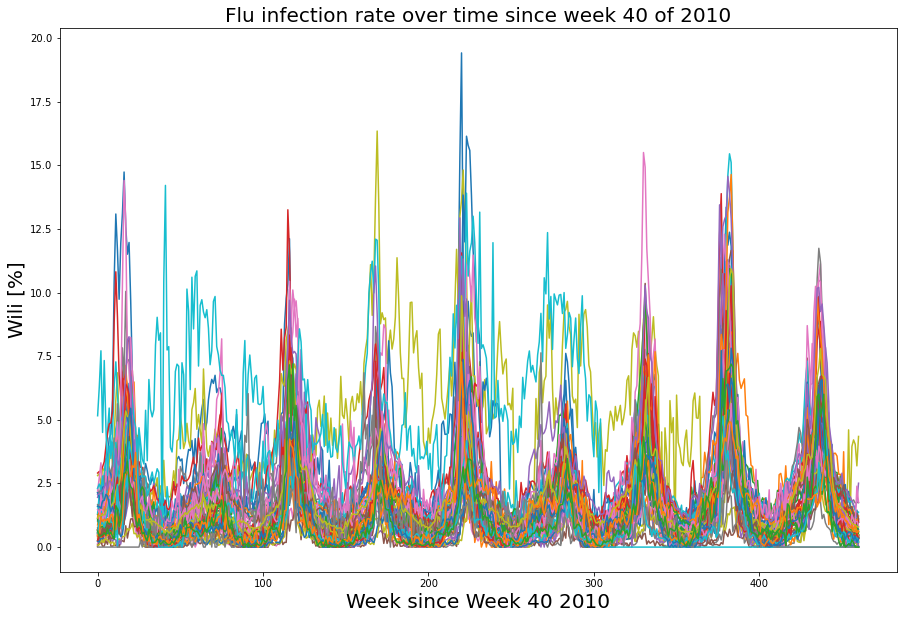

In [11]:
plt.figure(figsize = (15,10))
for state_name in data.columns:
    if state_name != 'time':
        plt.plot(range(len(data)), data[state_name])
plt.xlabel('Week since Week 40 2010', fontsize = 20)
plt.ylabel('Wili [%]', fontsize = 20)
plt.title('Flu infection rate over time since week 40 of 2010', fontsize = 20)

In [6]:
# check the NaN
nans = []
for state_name in data.columns:
    if state_name != 'time':
        nans_state = data[state_name].isna().sum()
        if nans_state != 0:
            print('For {}, there are {} NaNs'.format(state_name, nans_state))
        nans.append(nans_state)

For Puerto Rico, there are 156 NaNs
For Virgin Islands, there are 52 NaNs


In [7]:
# we will now fill in these Nans with 0
data.fillna(0, inplace = True)

### 1. Autoregressive (AR) Model

In an Autoregressive model, it is assumed that the output variable depends linearly on its previous values in time. Or mathematically:

$$X_{t}=c+\sum _{{i=1}}^{p}\varphi _{i}X_{{t-i}}+\varepsilon _{t}\,$$

Where $p$ is the order of the AR model, which comes down to the number of previous values that are relevant for the prediction of the future value. This is model that is commonly used for time series but it relies on the assumption that the all values are strongly correlation with the next value. Let's first have a look at that using a lagplot. 

Text(0.5, 1.0, 'Lagplot for all states')

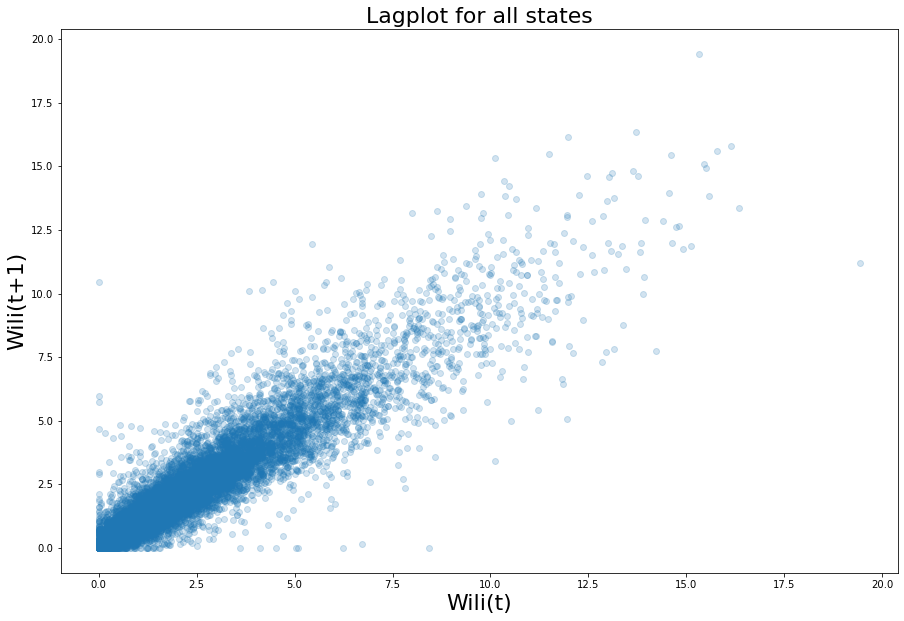

In [48]:
plt.figure(figsize = (15,10))
for state_name in data.columns:
    if state_name != 'time':
        pd.plotting.lag_plot(data[state_name], alpha = 0.2)
plt.xlabel('Wili(t)', fontsize = 22)
plt.ylabel('Wili(t+1)', fontsize = 22)
plt.title('Lagplot for all states', fontsize = 22)

This looks very correlated! Let's quantify this for every state using the correlation coefficient. 

Text(0.5, 1.0, 'Autocorrelation coefficient per state for lag = 1')

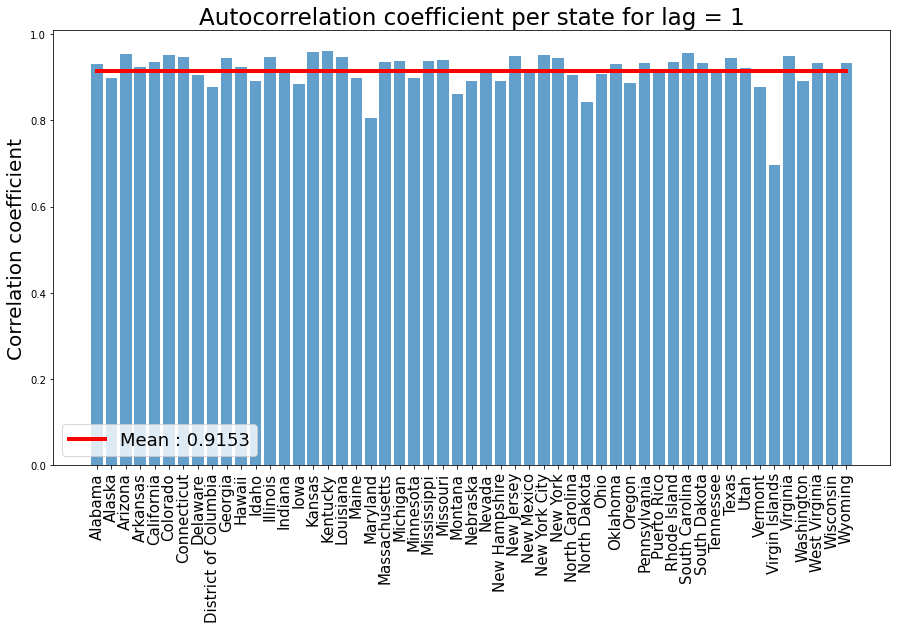

In [168]:
auto_corr = dict()

for state_name in data.columns:
    if state_name != 'time':
        values = data[state_name]
        df = pd.concat([values.shift(1), values], axis = 1)
        corr = df.corr().values[0,1]
        auto_corr[state_name] = corr
mean = np.mean(list(auto_corr.values()))
plt.figure(figsize = (15,8))
plt.bar(range(len(auto_corr)), list(auto_corr.values()), align='center', alpha = 0.7)
plt.plot(range(len(auto_corr)), np.ones(len(auto_corr))*mean,
        c = 'red', label = 'Mean : {}'.format(np.round(mean,4)), linewidth=4)
plt.legend(fontsize = 18)
plt.xticks(range(len(auto_corr)), list(auto_corr.keys()), rotation = 90, fontsize = 15)
plt.ylabel('Correlation coefficient', fontsize = 20)
plt.title('Autocorrelation coefficient per state for lag = 1', fontsize = 23)

Text(0.5, 1.0, 'Autocorrelation vs lag for all states')

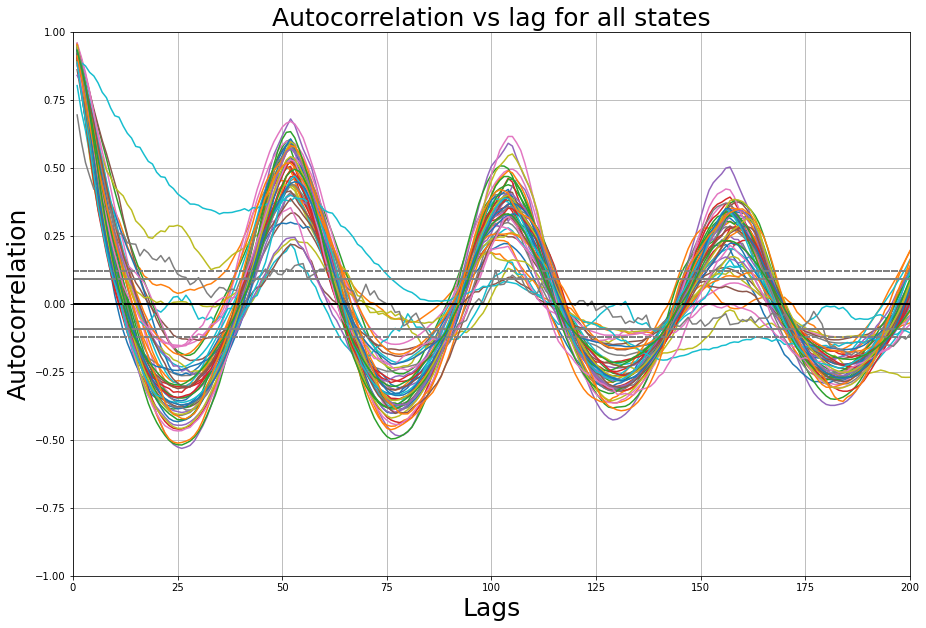

In [60]:
plt.figure(figsize = (15,10))
for state_name in data.columns:
    if state_name != 'time':
        pd.plotting.autocorrelation_plot(data[state_name])
plt.xlim([0,200])
plt.xlabel('Lags', fontsize = 25)
plt.ylabel('Autocorrelation', fontsize = 25)
plt.title('Autocorrelation vs lag for all states', fontsize = 25)

Now we know that the autocorrelation is significant up to a reasonable amount of lags. Based on the figure above, it is fair to say that we should not test a lag-size above 10, the actual size used in the model will be a hyperparameter to tune. Let's now try to build the AR model and evaluate it by computing the MSE on the test set, for which we will consider the last 50 values in the dataset. For each number of lags, we will compute the average MSE for all states over the test set. 

In [163]:
n_test = 50
lags = range(1,50)
av_mses_train = []
av_mses_test = []
for lag in lags:
    mses_train = []
    mses_test = []
    for state_name in data.columns:
        if state_name != 'time':
            X = data[state_name].values
            train, test = X[:len(X)-n_test], X[len(X) - n_test:]
            model = AutoReg(train, lags = lag)
            model_fit = model.fit()
            # make predictions
            predictions_train = model_fit.predict(start=lag, end=len(train)-1, dynamic=False)
            predictions_test = model_fit.predict(start=len(train), end=len(train)+len(test)-1, 
                                                 dynamic=False)
            mse_train = mean_squared_error(train[lag:], predictions_train)
            mse_test = mean_squared_error(test, predictions_test)
            mses_train.append(mse_train)
            mses_test.append(mse_test)
    av_mse_train = np.mean(mses_train)
    av_mses_train.append(av_mse_train)
    av_mse_test = np.mean(mses_test)
    av_mses_test.append(av_mse_test)
    #print('For {} lags, the average test MSE is: {}'.format(lag, av_mse))

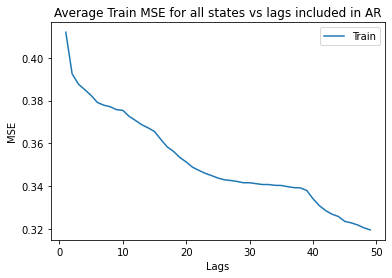

Text(0.5, 1.0, 'Average Test MSE for all states vs lags included in AR')

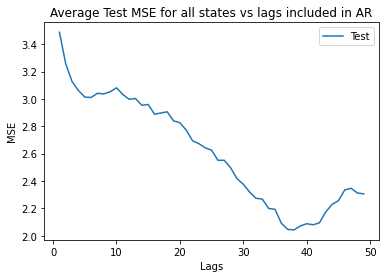

In [164]:
plt.figure()
plt.plot(lags, av_mses_train, label = 'Train')
plt.xlabel('Lags')
plt.ylabel('MSE')
plt.legend()
plt.title('Average Train MSE for all states vs lags included in AR')
plt.show()
plt.figure()
plt.plot(lags, av_mses_test, label = 'Test')
plt.xlabel('Lags')
plt.ylabel('MSE')
plt.legend()
plt.title('Average Test MSE for all states vs lags included in AR')

In [165]:
opt_lag = np.argmin(av_mses_test)
opt_lag

37

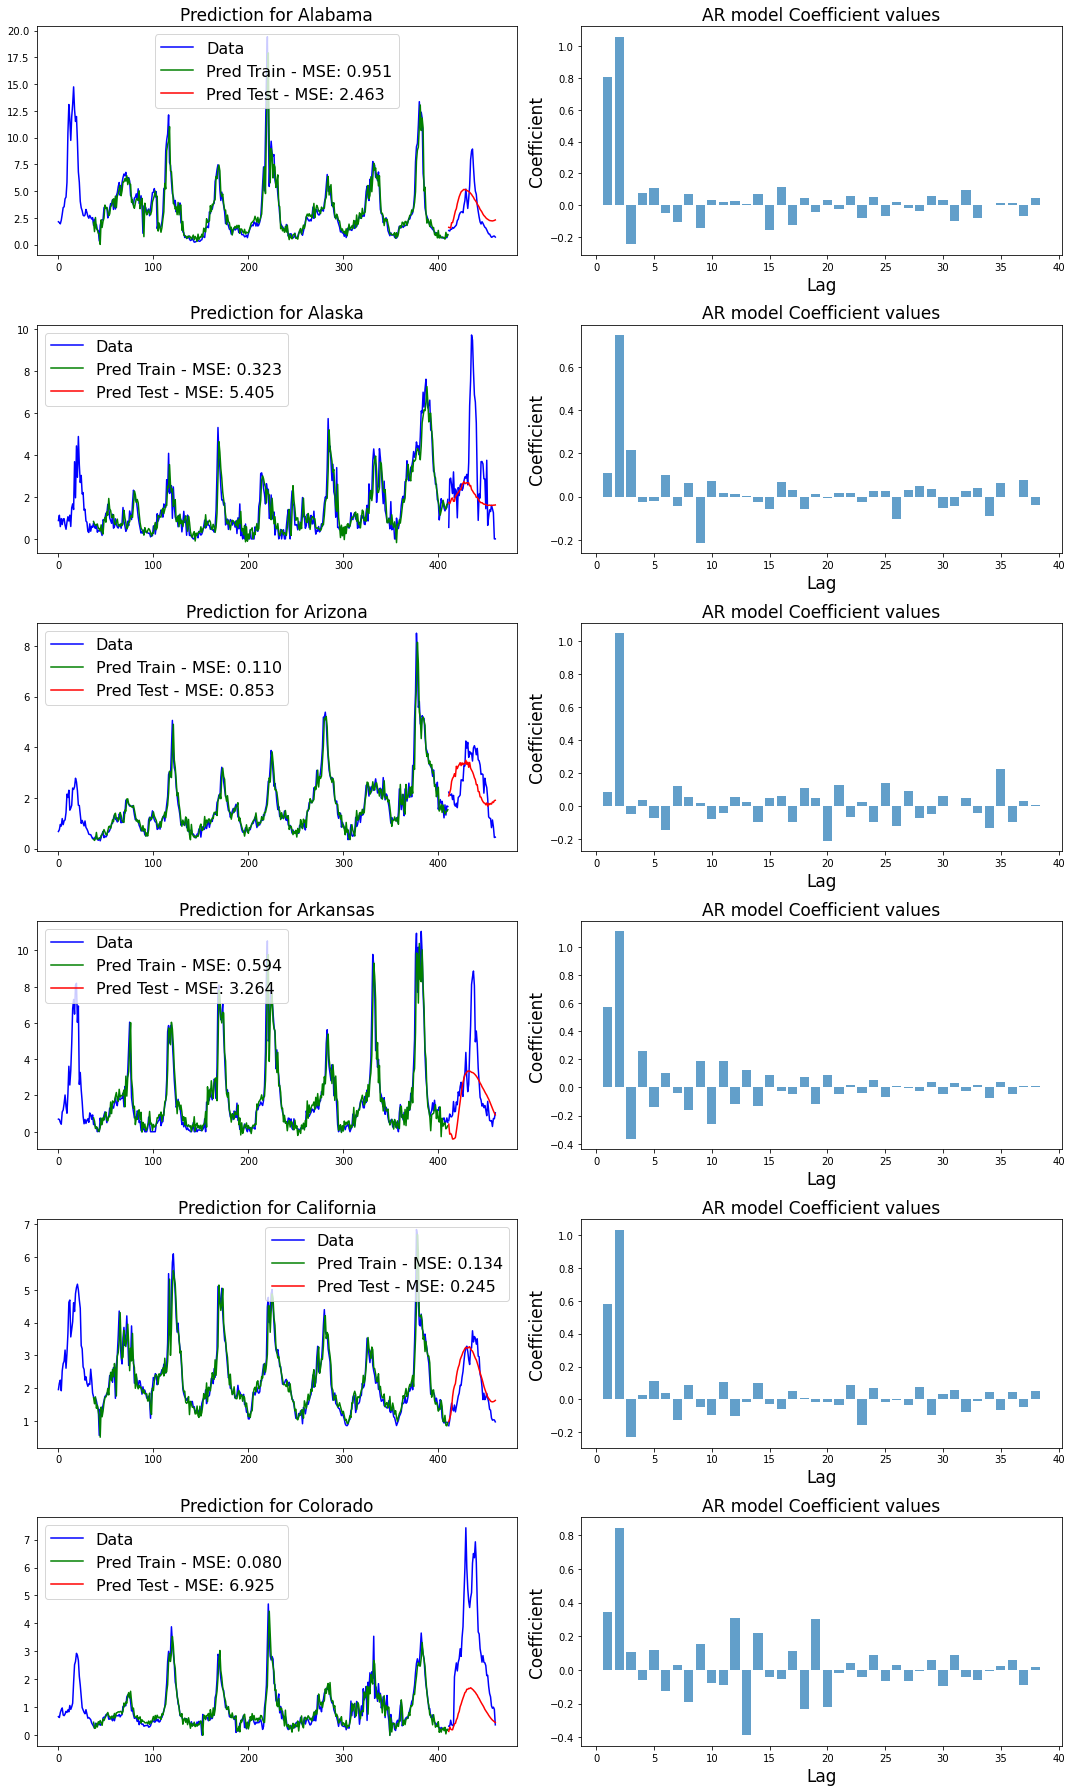

In [167]:
n_test = 50
lag = opt_lag

fig, ax = plt.subplots(6, 2, figsize=(15,25))

for i, state_name in enumerate(data.columns[1:7]):
    X = data[state_name].values
    train, test = X[:len(X)-n_test], X[len(X) - n_test:]
    model = AutoReg(train, lags = lag)
    model_fit = model.fit()
    coefs = model_fit.params
    # make predictions
    predictions_train = model_fit.predict(start=lag, end=len(train)-1, dynamic=False)
    predictions_test = model_fit.predict(start=len(train), end=len(train)+len(test)-1, 
                                         dynamic=False)
    mse_train = mean_squared_error(train[lag:], predictions_train)
    mse_test = mean_squared_error(test, predictions_test)
        
    ax[i,0].plot(range(len(train)), train, label = 'Data', c = 'blue')
    ax[i,0].plot(range(len(train), len(train)+len(test)), test, c = 'blue')
    ax[i,0].plot(range(lag, len(train)), predictions_train, 
                 label = 'Pred Train - MSE: %.3f' % mse_train, c = 'green')
    ax[i,0].plot(range(len(train), len(train)+len(test)), 
                 predictions_test, label = 'Pred Test - MSE: %.3f' % mse_test, c = 'red')
    ax[i,0].legend(fontsize = 16)
    ax[i,0].set_title('Prediction for {}'.format(state_name), fontsize = 17)
    ax[i,1].bar(range(1,len(coefs)+1), coefs, align='center', alpha = 0.7)
    ax[i,1].set_xlabel('Lag', fontsize = 17)
    ax[i,1].set_ylabel('Coefficient', fontsize = 17)
    ax[i,1].set_title('AR model Coefficient values', fontsize = 17)
plt.tight_layout()